<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment01/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
##Nama  : Sapto Nugroho
##NIU   : 565712

In [7]:
!ls

128x128.jpg  4x4.jpg	8x8.jpg     grid02.jpg	PCD_Assignment01.ipynb
16x16.jpg    64x64.jpg	grid01.jpg  grid.jpg


In [ ]:
!git clone https://github.com/sapto-nugroho/PCD.git

In [ ]:
!git pull origin main

In [8]:
import cv2
import pandas as pd
import numpy as np
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

###Image Acquisition

(5, 5, 3)
[[[  2   2   2]
  [ 41  41  41]
  [ 12  12  12]
  [143 143 143]
  [ 61  61  61]]

 [[ 79  79  79]
  [144 144 144]
  [255 255 255]
  [105 105 105]
  [255 255 255]]

 [[255 255 255]
  [ 56  56  56]
  [ 35  35  35]
  [255 255 255]
  [252 252 252]]

 [[191 191 191]
  [255 255 255]
  [255 255 255]
  [  1   1   1]
  [192 192 192]]

 [[ 31  31  31]
  [255 255 255]
  [104 104 104]
  [252 252 252]
  [255 255 255]]]


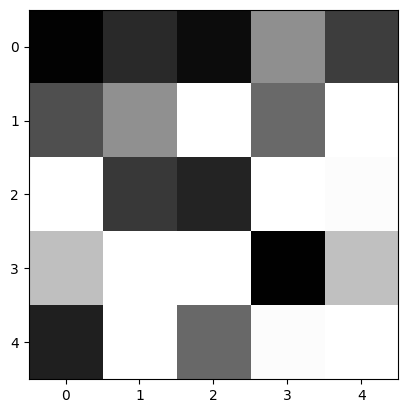

In [29]:
##Image 1
# img01_path = '/content/PCD/PCD_Assignment01/grid01.jpg'

# img1 = mpimg.imread(img01_path)
# plt.imshow(img1)
# plt.axis('off')
# plt.show()

# img01 = plt.imread(img01_path)
# print(img01.shape)
# print(img01[1][1])
# print(img01.flatten())


#Image 2
img02_path = '/content/PCD/PCD_Assignment01/grid02.jpg'

# img2 = mpimg.imread(img02_path)
# plt.imshow(img2)
# plt.axis('off')
# plt.show()

img02 = plt.imread(img02_path)
plt.imshow(img02)
print(img02.shape)
print(img02)


###Downsampling

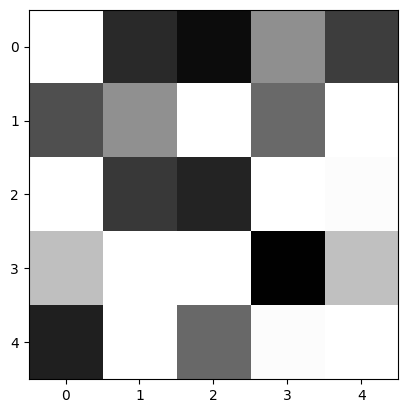

In [88]:
img02_copy = img02.copy()
img02_copy[0][0][0] = 255
img02_copy[0][0][1] = 255
img02_copy[0][0][2] = 255
plt.imshow(img02_copy)
# img02_copy.shape
# print(img02_copy)

2
sisa baris 1
2
sisa kolom 1
[[[0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]]]
[[[255 255 255]
  [ 12  12  12]]

 [[255 255 255]
  [ 35  35  35]]]


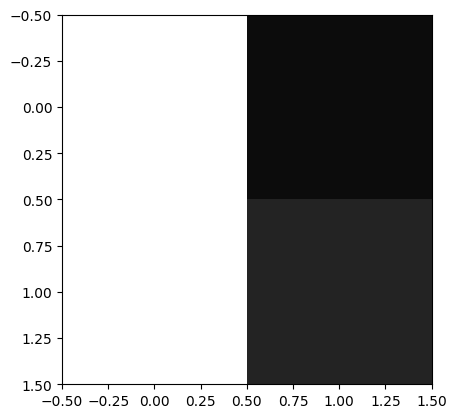

In [91]:
#baris
div = 2
baris = img02_copy.shape[0]//div
print(baris)
print("sisa baris", img02_copy.shape[0]%2)

#kolom
kolom = img02_copy.shape[1]//div
print(kolom)
print("sisa kolom",img02_copy.shape[1]%2)

#template matriks downsample
M_DS = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
print(M_DS)

for j in range(0,M_DS.shape[1]):
  # print(j)
  for i in range(0,M_DS.shape[0]):
    # print(i)
    M_DS[j][i] = img02_copy[j*div][i*div]
    # print(img02_copy)
print(M_DS)
plt.imshow(M_DS)

In [79]:
print(M_DS[0][0])
M_DS[0][0] = img02_copy[0][0]
print(M_DS[0][0])

[0 0 0]
[255 255 255]


In [49]:
# pd.Series(img01.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

flat = img02.flatten()
# print(flat.shape)
# print(flat)

A = []

for i in range(len(flat)):
  if i%3==0:
    A.append(int(flat[i]))

A = np.array(A)
print(A[0].dtype)

# pd.Series(img02.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

int64


In [ ]:
#commit ke-12

##junk

In [ ]:
# length = len(flat)/3
# length = int(length)

# empty02 = np.zeros(shape=(length),dtype=np.uint8)
# print(empty02)